# Computer Vision - P3


## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): November 10th, 23:00 h** 

## Before starting

In [5]:
# Libraries we will use for this practicum
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage
from skimage import io, exposure, segmentation, img_as_float
from skimage.exposure import histogram

In [6]:
"""
This function display the images with the settings defined below. 
We will use this function in the following funtion.

@params
    img: where we will display the image
    image: the image to display
    gray: boolean if we will use cmap to display the image
    title: the title that the image will have
    axis: if we want to use or not axis, predefined as 'off'.
    
"""

def subplot_image(img, image, gray, title="", axis="off"):
    img.axis(axis)
    img.set_title(title)
    if gray:
        img.imshow(image,cmap='gray')
    else:
        img.imshow(image)


"""
This function display the images in order.

@params
    images: list of images to display
    titles: list of titles that each image will have
    gray: list of booleans for each image. if True we will use cmap to display the image
    rows: number of rows we want to use to display the images
    cols: number of cols we want to use to display the images
    
"""

def plot_images(images=[],titles=[],gray=[],rows=0,cols=0):
    
    # First we check if we have one cell per image
    if (rows * cols) < (len(images)):
        print(colored("Attention! The dimensions of the subplot are incorrect!","red"))
        return
    
    # Create a subplot
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 5))

    # Index to acces the values of the lists (images, titles, gray)
    index = 0 
    total = len(images)
    
    for i in range(rows):
        for j in range(cols):
            
            if index < total:
                
                if rows == 1 and cols == 1:
                    img = axs
                
                elif rows == 1:
                    img = axs[j]
                
                else:
                    img = axs[i,j]
                    
                subplot_image(img, images[index], gray[index], titles[index])
                
            else:
                image = axs[i,j]
                image.axis('off')
                
            index += 1
            
    #Finally display the subplot
    plt.show()

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

In Video Segmentation:

3.1. Segmentation of video shots with static scenes.

3.2. Background substraction.

In Image Segmentation:

3.3. Segmentation of images.

To successfuly complete this practicum it is necessary to understand the following theory concepts: video segmentation, background substraction, K-means clustering, different image segmentation approaches,...

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.



## Video segmentation

Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, we ask you to:
- Find the temporal segments of the video (shots). Where the scene change? (Section 3.1)
- Extract the background images and thus, remove all the "artifacts" considered as foreground related to movement. (Section 3.2)


Note: One of the applications of the backgroun substraction methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Today, most of videoconference tools allow to put a virtual background. Thus, they need to extract the person (the foreground) and to put it on the new virtual background.


## 3.1 Segmentation of video shots

Read and visualize the sequence of images "images/Barcelona-sequence".

Hint: In order to read a collection of images, we wil use the function [animation.FuncAnimation](https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html).

Observe in the following Example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

In [38]:
%matplotlib inline

Traceback (most recent call last):
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


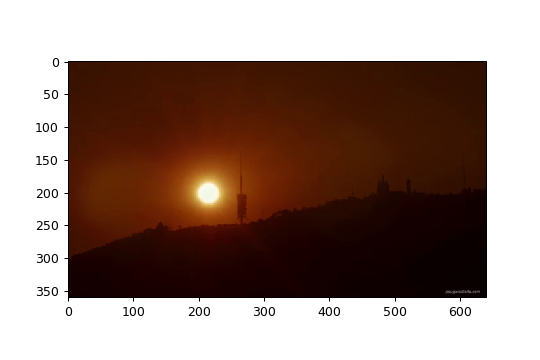

In [8]:
# Example


ic = io.ImageCollection('images/Barcelona-sequence/*.png')
        # Reading a sequence of images from a folder


%matplotlib nbagg 
    #Changing the pluggin is necessary always when visualizing a video!

fig = plt.figure()  # Create figure
im = plt.imshow(ic[0], animated=True) #Visualize the first image

def updatefig1(i):   #Updating the frame visualization
    im.set_array(ic[i*5]) #Changing the content of the canvas
    return im, #to return a tuple!

plt.show()
ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=True, frames=50, repeat= False)
plt.show()

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. 

To solve this exercise, you need to create a **temporal plot** showing a frame by frame measure to be defined by you, being applicable to distinguish the shots. Define a criterion to detect the boundaries of the shots and visualize it in a static plot.

C:\Users\ian18\Anaconda3\lib\site-packages\skimage\exposure\exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


<IPython.core.display.Javascript object>


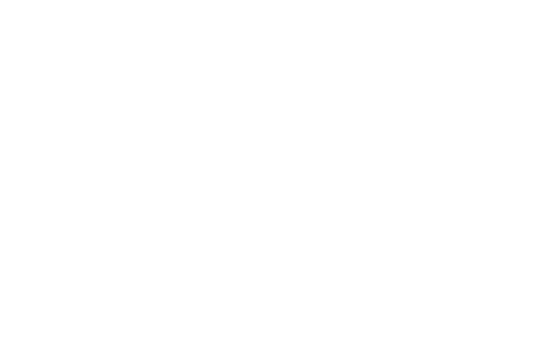

<IPython.core.display.Javascript object>


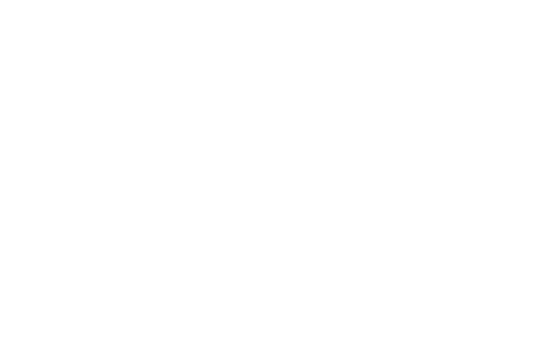

 -+-+-+- Scenes frames -+-+-+- 
The scene number: 1 starts at the frame 0 and ends at the frame 102
The scene number: 2 starts at the frame 103 and ends at the frame 194
The scene number: 3 starts at the frame 195 and ends at the frame 287
The scene number: 4 starts at the frame 288 and ends at the frame 289


In [9]:
# Your soluction here

# First we'll define the methods to use

# This method will compute the mean pixel intensity, as we convert our image to float, we normalize
# and then we can get a decimal value between 0 and 256 and get the mean intensity doing an average simple process
def get_intensity(image_histogram):
    image_intensity = np.sum(image_histogram * np.arange(256)) / np.sum(image_histogram)
    return image_intensity

# This method will measure a video based in the intensity of each frame, 
# then get the difference between the intensities of the frames
# Using a threshold, it'll define if there is a change of scene
# Parameters are:
#     - ic: The image sequence
#     - threshold: The value that will spot a change of scene 
def measuring_video(ic, threshold):
    # Some lists that we'll use for plotting
    #     - The intensities of the images
    #     - The change of intensity between images (setting the first value as 0, there is nothing to compare before)
    #     - The shot scenes (always saving the first frame, is the initial frame of the starting shot)
    intensities = np.array([])
    change_intensity = np.array([0])
    shot_scenes = np.array([0])

    first_image = img_as_float(ic[0])
    first_image_histogram = exposure.histogram(first_image)
    first_image_intensity = get_intensity(first_image_histogram[0])
    intensities = np.append(intensities, first_image_intensity)    

    # We go through all the sequence
    # We use the 'range - 1' because we're going to compare the whole set and we don't want to break the array
    for frame in range(len(ic) - 1):
        # Getting the image
        # We are converting it to float because is needed in order to operate with the histogram function
        # Then we get the histogram
        image = img_as_float(ic[frame])
        image_histogram = exposure.histogram(image)

        # Getting the next image
        # Converting it to float in order to get its histogram
        # Then we get its histogram
        next_image = img_as_float(ic[frame + 1])
        next_image_histogram = exposure.histogram(next_image)

        # Getting the mean pixel intensities of the images (we only need to pass the histogram)
        image_intensity = get_intensity(image_histogram[0])
        next_image_intensity = get_intensity(next_image_histogram[0])

        # Saving the mean pixel intensity of the next image
        intensities = np.append(intensities, next_image_intensity)

        # We get the mean pixel intensity change between frames (the images)
        # Then we save them
        intensity_change = np.abs(next_image_intensity - image_intensity)
        change_intensity = np.append(change_intensity, intensity_change)

        # If the change in the intensity if above the threshold
        # that means that there is a change of scene
        if intensity_change > threshold:
            # Save the index of frame of the image (the end of the actual scene)
            shot_scenes = np.append(shot_scenes, frame)
            
            # Save the index frame of the next image (the start of the next scene)
            shot_scenes = np.append(shot_scenes, frame + 1)
    
    # Save the index of the last frame in the sequence
    shot_scenes = np.append(shot_scenes, (len(ic) - 1))

    # Return the arrays with all the intensities, the change of the intensities and
    # the index of the frames that start and end the scenes
    return intensities, change_intensity, shot_scenes


# Loading the image sequence
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

# Calling the method, we'll use a threshold of 10
images_intensities, intensities_changes, scene_frames = measuring_video(ic, 10)

# Create an x axis values pre-plotting
x_axis = np.array([index for index in range(len(ic))])

# Let's plot the results

# Intensities along the video
fig = plt.figure()
plt.plot(x_axis, images_intensities, 'b')
plt.title('Intensity along the frames')
plt.xlabel('# of frame')
plt.ylabel('Intensity')
plt.show()

# Intensity change along the video
fig = plt.figure()
plt.plot(x_axis, intensities_changes, 'g')
plt.title('Change of intensity along the frames')
plt.xlabel('# of frame')
plt.ylabel('Intensity')
plt.show()

# Printing frames of the scenes
print(' -+-+-+- Scenes frames -+-+-+- ')

counter = 1
for i in range(0, len(scene_frames), 2):
    print('The scene number:', counter, 'starts at the frame', scene_frames[i], 'and ends at the frame', scene_frames[(i + 1)])
    counter += 1
    
# Just a note: The images at the video start at 1, so even the frames match, if we count from 1
# there frames we gave are the one we gave + one

Additionally, create an interactive plot executing the following code in "Example A". This created **temporal plot** should replace the temporal plot given as a template. 

Traceback (most recent call last):
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


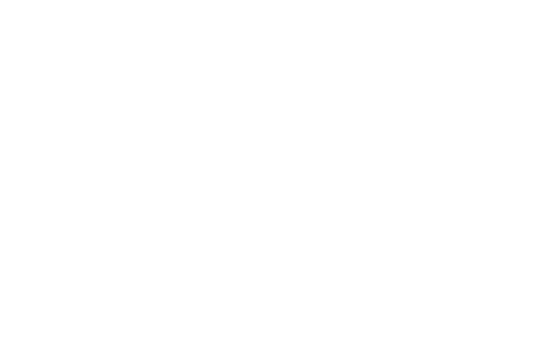

In [10]:
# Example A
# Sinusoidal plot points generation
def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt+=1
        t += 0.05
        y = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(-1.1, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10, repeat=False)
plt.show()

Traceback (most recent call last):
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\ian18\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


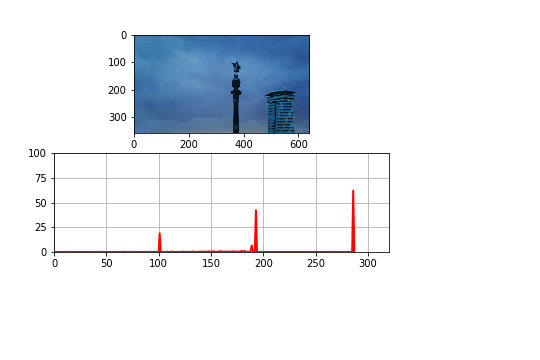

In [11]:
# Your soluction here
def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < len(ic):
        cnt+=1
        t += 1
        yield t

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 50)
ax2.set_xlim(0, 10)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []

def run(data):
    # update the data plot
    t = data
    xdata.append(t) # time = x axis
    
    # Getting the image
    # Converting the image to float so we can operate with the histogram
    image = ic[len(xdata)]
    image = img_as_float(image)

    # Getting the image
    # Converting the image to float so we can operate with the histogram    
    next_image = ic[len(xdata) + 1]
    next_image = img_as_float(next_image)
    
    # Getting the histogram of the image and the next image
    image_histogram = exposure.histogram(image)
    next_image_histogram = exposure.histogram(next_image)
    
    # Lets calculate the mean pixel intensity of both images
    image_intensity = np.sum(image_histogram[0] * np.arange(256)) / np.sum(image_histogram[0])
    next_image_intensity = np.sum(next_image_histogram[0] * np.arange(256)) / np.sum(next_image_histogram[0])        
    
    # Now get the intensity change between frames
    intensity_change = np.abs(next_image_intensity - image_intensity)        
        
    # Append it to the y axis data    
    ydata.append(intensity_change) # y axis

    # Plot image on top row
    ax1.imshow(image)
              
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
    if intensity_change >= ymax:
        ax2.set_ylim(ymin, 2*ymax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)
    
    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=1, repeat=False)
plt.show()

b) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


**Hint:**
Use the previous plot to define the proper threshold value over the differences of histograms. Use the threshold to localize the initial and final frames.


<IPython.core.display.Javascript object>


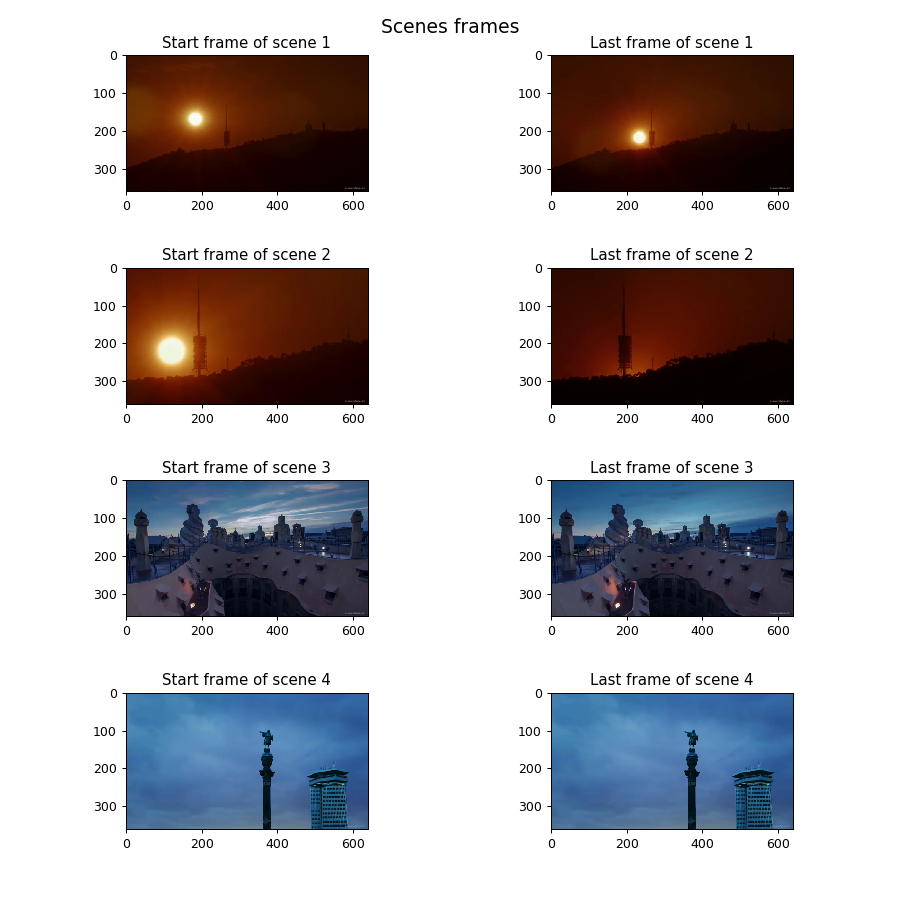

In [22]:
# Your soluction here

# This method will get all the index of the frames that are in the y data generated by the previous plot
# and using a threshold we can get the start and end frames of each scene
def get_scene_frames(values, threshold):
    # The list that will save the index of the frames
    start_end_frames = list()
    
    # We'll use an enum in order to get the index and measure the value against the threshold
    for index, value in enumerate(values):
        # Always save the index 0 (is the first image of the first shot)
        if index == 0:
            start_end_frames.append(index)
        else:
            # If the value is above the threshold save the proper frames
            # The one that ends the current scene (we use + 1 due to the way we generated the y data before)
            # The one that starts the next scene (we use + 2 due to the way we generated the y data before)
            if value > threshold:
                start_end_frames.append(index + 1)
                start_end_frames.append(index + 2)
                
    # And of course, always save the last index (Is the last frame of the last shot)
    # The + 1 is due the way we generated the y data before
    start_end_frames.append((len(values) + 1))

    # Now we just order the start and end frame of each scene in tuples
    ordered_frames = list()
    
    for i in range(0, len(start_end_frames), 2):
        ordered_frames.append((start_end_frames[i], start_end_frames[i + 1]))
    
    # Finally return the list of tuples
    return ordered_frames 

# Calling the function
the_scene_frames = get_scene_frames(ydata, 10)

# Loading the image sequence
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

# Ploting the scenes
fig, scene = plt.subplots(len(the_scene_frames), 2, figsize=[10, 10])
fig.tight_layout(pad=4.0)
fig.suptitle('Scenes frames', fontsize=15)
for shot in range(len(the_scene_frames)):
    # Showing the first scene of the shot
    scene[shot][0].imshow(ic[the_scene_frames[shot][0]])
    scene[shot][0].set_title('Start frame of scene ' + str((shot + 1)))

    # Showing the last scene of the shot
    scene[shot][1].imshow(ic[the_scene_frames[shot][1]])
    scene[shot][1].set_title('Last frame of scene ' + str((shot + 1)))

c) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

We solve this problem in the basis that the frames in a shot, since they're a sequencial, are similar between them, so, we use the mean pixel intensity of each image, using the histogram function of skimage over a RGB image.

Then with a given threshold we can split the sequence based in that if the mean pixel intensity change between frames is higher than that threshold, that means that a shot ends and another starts.

In the plot this is easy to see, the big changes are (obviusly) greater than the small ones, and this is reflected in the graph as those great incrementations, so all that tips means that probably a scene ended and another started.

d) Would your video segmentation strategy be able to capture continuous transition? Argue your answer.

Sadly, but no.

Mmm... We would like to say yes, but, we cannot assure this, so, unless the given threshold could satisfy the situation, this won't works, because a more similar images, more similar histograms, so, more similar mean pixel intesities.

Probably using another approximation based in the pixel positions to see changes between frames, this could be possible, but our approach can't do this always, a good threshold is precised, and this is pretty hard to get without previous information. 

e) Would your video segmentation strategy be able to separate and track objects? Argue your answer.

No, this algorithm works globally with all the pixels of the image, so, what we meant with this, is not designed to observe the pixels and track their changes, so we couldn't track nor separate the objects in the image.

## 3.2 Background subtraction

Apply the background subtraction algorithm (check theory material).

a) Visualize the following images for each different scene (there are 3) of the video:

    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

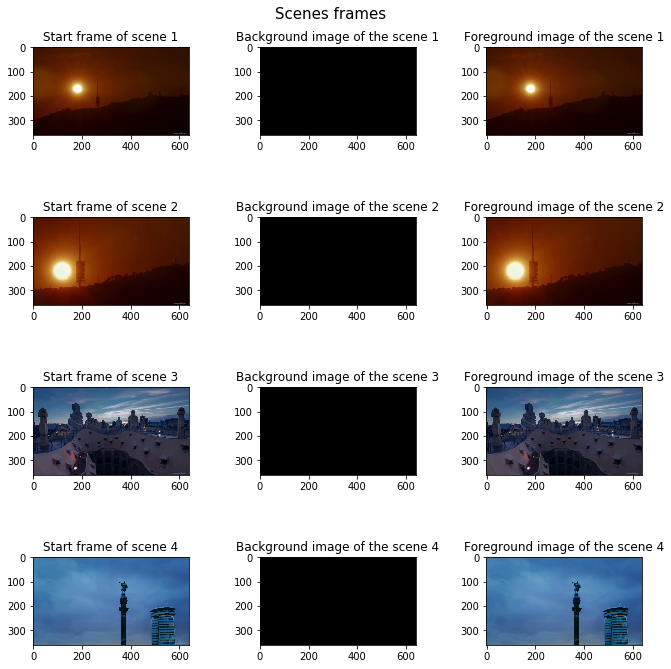

In [46]:
# Your soluction here
# Loading the image sequence
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

# Calling the method, we'll use a threshold of 10
images_intensities, intensities_changes, scene_frames = measuring_video(ic, 10)

# We will only use the start and end frames of the scenes
def get_background_and_foreground_image(ic, start_frame, end_frame):
    scene_images = ic[start_frame : (end_frame + 1)]
    Rpixels, Gpixels, Bpixels = list(), list(), list() 
    avg_values = list()
    background_image = np.zeros_like(scene_images[0])
    foreground_image = np.zeros_like(background_image)
    
    for image in scene_images:
        image = img_as_float(image)
        avg_values += [image]
        
        Rpixels += [image[:, :, 0]]
        Gpixels += [image[:, :, 1]]
        Bpixels += [image[:, :, 2]]

    background_image[:, :, 0] = np.median(Rpixels, axis=0)
    background_image[:, :, 1] = np.median(Gpixels, axis=0)
    background_image[:, :, 2] = np.median(Bpixels, axis=0)
    
    foreground_image = np.abs(avg_values[0] - background_image)
    
    return background_image, foreground_image

background_and_foreground_images = list()

for i in range(len(the_scene_frames)):
    background_image, foreground_image = get_background_and_foreground_image(ic, the_scene_frames[i][0], the_scene_frames[i][1])
    background_and_foreground_images.append((background_image, foreground_image))
    
# Ploting the images
figure, img = plt.subplots(len(the_scene_frames), 3, figsize=[10, 10])
figure.tight_layout(pad=4.0)
figure.suptitle('Scenes frames', fontsize=15)
for shot in range(len(the_scene_frames)):
        
    # Showing the first scene of the shot
    img[shot][0].imshow(ic[the_scene_frames[shot][0]])
    img[shot][0].set_title('Start frame of scene ' + str((shot + 1)))

    # Showing background image
    img[shot][1].imshow(background_and_foreground_images[shot][0])
    img[shot][1].set_title('Background image of the scene ' + str((shot + 1)))
    
    # Showing background image
    img[shot][2].imshow(background_and_foreground_images[shot][1])
    img[shot][2].set_title('Foreground image of the scene ' + str((shot + 1)))

b) Comment your implementation including details. 

c) Answer the following questions:
- What happens if the shots are not correctly extracted? 
- What happens if you find too many shots in the video? 
- What do the static background images represent? 
- In which situations does the algorithm work and in which it does not? 
- What happens if you substract the background image from the original one?
- Do you see any additional application for this algorithm?

d) **[OPTIONAL]**
- Apply the algorithm to some other static video that you found.

## Questions
#### What happens if the shots are not correctly extracted?
If we aren't extracting properly the shots and instead we take an image from other shot, in the moment we apply the median filter we won't get the correct background.
#### What happens if you find too many shots in the video?
In this case, the problem might be the limit we put is not proportional to the changes of the scene. This problem will take more shots on powerful change colors, so we have to manage this with the limit.
#### What do the static background images represent?
These are all the elements which remain in the background when the scene changes.
#### In which situations does the algorithm work and in which it does not?
This algorithm might have problems as we said before in determining the limit (it have to be proportional over all the scene shots). Moreover, this algorithm won't work well if the elements which are in movement moves too slowly (this will cause that we won't be able to extract correctly the background, we will get a mixed of all the frames).
#### What happens if you substract the background image from the original one?
We might get elements which are moving on the image and won't belong to the real background.
#### Do you see any additional application for this algorithm?
This algorithm could be interesting for video surveillence, human machine interaction, gait recognition or any other multimedia application.

In [ ]:
# Your soluction here

## 3.3 Segmentation of images

Apply different clustering methods for image segmentation on the RGB-XY space.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)

In [ ]:
%matplotlib inline

a) Read 'loro.png' image from the folder 'images' and segment it using Felzenszwalbs's method. 


In [ ]:
# Load image loro.png
loro_img = io.imread('images/loro.png')

# Segment the image in different clusters
segmented_felz_img = segmentation.felzenszwalb(loro_img) # We are not using the params for this part

# Mar all the clusters with a yellow line
marked_felz_img = segmentation.mark_boundaries(loro_img, segmented_felz_img)

# Display
plot_images([loro_img, marked_felz_img], ["Original image", "Segmented by Felzenszwalb's method"], [False,False],1,2)

b) Test different parameters in order to obtain a good image segmentation. 
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?


In [ ]:
# Segment the image in different clusters
segmented_felz_img = segmentation.felzenszwalb(loro_img, 250, 1, 50) # params: image, scale, sigma, min_scale

# Mar all the clusters with a yellow line
marked_felz_img = segmentation.mark_boundaries(loro_img, segmented_felz_img)

# Display
plot_images([loro_img, marked_felz_img], ["Original image", "Segmented by Felzenszwalb's method"], [False,False],1,2)

## Questions
#### Which are the optimal values?
We were modifying the sigma and scales values since we thought that we found the correct segmentations. For this image we think that the optimal values are: scale = 250, sigma = 1 (with a bigger sigma we couldn't find a way to get the details of the plant) and min_scale = 10.
#### How does each parameter behave?
For the felzenswalb function we have the following parameters:
- scale: represents the size of the clusters. The lower the value is, the most sensible we get.
- sigma: used for the gaussian function so we smooth the image before segmenting it. The higher the value, is the more smooth the image gets.
- min_scale: is the minimum value that the cluster gets. The lower the value is, the more details we get from the image (especially from the plant).
- multichannel: default value True. This parameter tells the function if we want to interpret the last axis of the image as multple channels.


c) Comment what algorithm is the method based in up to 3 lines most.

The algorithm is based on Kruskal's MST algorithm. As the scikit-image documentation says it produces an oversegmentation of a multichannel (i.e. RGB) image using a fast, minimum spanning tree based clustering on the image grid.

d) Segment the same image using SLIC algorithm. 

In [ ]:
# Segment the image in different clusters
segmented_slic_img = segmentation.slic(loro_img) # Without params

# Mar all the clusters with a yellow line
marked_slic_img = segmentation.mark_boundaries(loro_img, segmented_slic_img)

# Display
plot_images([loro_img, marked_slic_img], ["Original image", "Segmented by SLIC's method"], [False,False],1,2)

e) Test different parameters in order to obtain a good image segmentation with SLIC algorithm.
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?

In [ ]:
# Segment the image in different clusters
segmented_slic_img = segmentation.slic(loro_img, sigma=2, min_size_factor = 0.15, max_size_factor=3)
# Mar all the clusters with a yellow line
marked_slic_img = segmentation.mark_boundaries(loro_img, segmented_slic_img)

# Display
plot_images([loro_img, marked_slic_img], ["Original image", "Segmented by SLIC's method"], [False,False],1,2)

## Questions
#### Which are the optimal values?
First of all, we recommend to read first the answer of the question below in order to get familiarized with the parameters of this function. Now, since there are so many possibilities of combination of parameters, we will use only the ones we think will give us a biggest impact in the results. We think that with sigma=2, min_size_factor=0.15 and max_size_factor=3 we get to a optimal result where we can observre the majority of the details.
#### How does each parameter behave?
For this function we have much more parameters than in the felzenszwalb's one. We have been looking around and playing with the values of this parameters and with the help of the skicit-image documentation we could understand how the parameters behave:
- n_segments: the (aproximate) number of segmentations we want. Looking at the image we don't know if we always have the number of segmentation we specify since the marking borders are larger than others and they aren't very clearly to see where they start and where they finish.
- compactness: a float value which represents the space proximity between the borders. This value depends a lot of the image contrast and the shape of the objects in the image. Proving some values we could observer the higher the value is (100) the more cubic the space proximity gets. Furthermore, the lower the value is the more 'curly' the boundaries get.
- max_iter: the number of iterations we want to perform. The more iterations we put the more details we get, but instead the program gets slowly. There is a point that putting more iteration doesn't make any effect on getting more details, so we should be careful with this value (as like the other ones of course).
- sigma: performs as before, this value gets the image smoother before applying the segmentations.
- spacing: a lists (size 3) of floats which controls the weights of the distances.
- multichannel: just like in the previous function this parameter tells the function if we want to interpret the last axis of the image as multple channels.
- convert2lab: this parameter requires the image to be RGB and converts to Lab colorspace prior to segmentation. The default value is true if the multichannel == True and image.shape[-1] == 3.
- enforce_connectivity: boolean value to determinate if the segments are connected or not.
- min_size_factor: proportion to be removed with respect to the supposed segment size. This parameter is important for example to remove the yellow boundaries we can observerse in the sky, ocean and earth in the d) section.
- max_size_factor: proportion of the maximum connected segment size.
- slic_zero: zero parameter of Slic. Chooses the comptactness factor adaptevily for each superpixel.
- start_label: label's index start. For version 0.17.
- mask: supepixels are computed only where the mask is True- For version 0.17.



f) Segment the same image using the Quickshift algorithm. 

In [ ]:
# Segment the image in different clusters
segmented_qs_img = segmentation.quickshift(loro_img) # Without params

# Mar all the clusters with a yellow line
marked_qs_img = segmentation.mark_boundaries(loro_img, segmented_qs_img)

# Display
plot_images([loro_img, marked_qs_img], ["Original image", "Segmented by Quickshift's method"], [False,False],1,2)

g) Test different parameters in order to obtain a good image segmentation with SLIC algorithm.
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?

In [ ]:
# Segment the image in different clusters
segmented_qs_img = segmentation.quickshift(loro_img, ratio=0.15)

# Mar all the clusters with a yellow line
marked_qs_img = segmentation.mark_boundaries(loro_img, segmented_qs_img)

# Display
plot_images([loro_img, marked_qs_img], ["Original image", "Segmented by Quickshift's method"], [False,False],1,2)

## Questions
#### Which are the optimal values?
For this function we are using only the ratio, since we think that with this parameter we have enough to get an optimal result. The assigned for ratio is 0.15. The other parameters and this one are explained in the following question. 
#### How does each parameter behave?
For the quickshift function we have the following parameters:
- ratio: balances the color-space proximity. The higher the value is, the more weight we give to color-space.
- kernel_size: width for the gaussian function to smooth the sample density. The higher the value is the fewer clusters we get.
- max_dist: cut-off point for data distances. The higher the value is the fewer clusters we get.
- return_tree: whether to return the the full segmentation. The return is a tuple with the segmentation hierarchy and distances.
- sigma: used for the gaussian function so we smooth the image before segmenting it. The higher the value, is the more smooth the image gets.
- convert2lab: this parameter requires the image to be RGB and converts to Lab colorspace prior to segmentation.
- random_seed: used for breaking ties.

h) Comment what algorithm is the method based in up to 3 lines.

This algorithm first finds the high density regions of the data and then clusters the remaining point by hill-climbing. 

i) Plot the original image and the results of both algorithms in a 1x3 subplot. 



In [ ]:
# THERE ARE 3 ALGORITHMS, since we don't know which 'both' algorithms the question refers to we will display all 3.
plot_images([loro_img, marked_felz_img, marked_slic_img, marked_qs_img], 
            ["Original image", "Segmented by Felzenszwalb's method", "Segmented by SLIC's method",
             "Segmented by Quickshift's method"], 
            [False, False, False, False],1,4)

j) Calculate also the number of segments obtained on the image by each of the algorithms. 

In [ ]:
n_segments_felz = len(np.unique(segmented_felz_img))
n_segments_slic = len(np.unique(segmented_slic_img))
n_segments_qs = len(np.unique(segmented_qs_img))

# Print number of segments of each function
print("Number of segments using Felzenszwalb's algorithm: ", n_segments_felz)
print("Number of segments using using SLIC algorithm: ", n_segments_slic)
print("Number of segments using using Quickshift algorithm: ", n_segments_qs)

k) Comment the differences between each method as well as their advantages and disadvantages.

First of all, we can observe that the 3 algorithms return a similar number of segments for this image, although we modified with the optimal values for the parameters of each function. One difference we noticed while we were running this functions, is that the Quickshift function is a bit slowly compared to the other ones. Let's compare, to see if this is true:

In [ ]:
import time

We will compare the average time of each function for n iterations in order to get a more realistic result. We will do for the functions with and without parameters changed, to see if that impacted the time of execution.
First we calculate the average time of each one without optional params:

In [ ]:
count = 0
n = 20 # Number of iterations we will do in order to calculate the average time
start_felz = end_felz = start_slic = end_slic = start_qs = end_qs = 0
while count < n:
    start_felz += time.time()
    segmented_felz_img = segmentation.felzenszwalb(loro_img)
    end_felz += time.time()

    start_slic += time.time()
    segmented_slic_img = segmentation.slic(loro_img)
    end_slic += time.time()

    start_qs += time.time()
    segmented_qs_img = segmentation.quickshift(loro_img)
    end_qs += time.time()
    
    count += 1
    
# Print results
print("Felzenszwalb time average: ", round((end_felz - start_felz)/n, 4), "s")
print("SLIC time average: ", round((end_slic - start_slic)/n, 4), "s")
print("Quickshift time average: ", round((end_qs - start_qs)/n, 4), "s")

Now we calculate it with params

In [ ]:
count = 0
n = 20 # Number of iterations we will do in order to calculate the average time
start_felz = end_felz = start_slic = end_slic = start_qs = end_qs = 0
while count < n:
    start_felz += time.time()
    segmented_felz_img = segmentation.felzenszwalb(loro_img, 250, 1, 50)
    end_felz += time.time()

    start_slic += time.time()
    segmented_slic_img = segmentation.slic(loro_img, sigma=2, min_size_factor=0.15, max_size_factor=3)
    end_slic += time.time()

    start_qs += time.time()
    segmented_qs_img = segmentation.quickshift(loro_img, ratio=0.15)
    end_qs += time.time()
    
    count += 1

# Print results
print("Felzenszwalb time average: ", round((end_felz - start_felz)/n, 4), "s")
print("SLIC time average: ", round((end_slic - start_slic)/n, 4), "s")
print("Quickshift time average: ", round((end_qs - start_qs)/n, 4), "s")

Seeing the results we can reach at 2 conlcusions. The first one is that the Quickshift is the slowest algorithm between these ones. The other 2 (SLIC and Felzenswalb) are pretty similar, although the SLIC is a bit faster the average time of execution is not as a big difference as the Quickshift's one.
The second conclusion is that the average time of execution doesn't make a big difference if we using the optional parameters of each function. Important, these times which we get is for the values we have put in the points b) e) and g). Changing the value of the parameters can alter the final result, specially the ones which include iterations. 

Now we are going to specify the pros and cons of each algorithm.

### Felzenswalb's image segmentation algorithm
#### Advantages
- It only has one parameter 'scale' which influences in the segment size, so it's pretty easy to use.
- It's an efficient graph algorithm.
- With the sigma we can smooth the image before doing the segmentation.

#### Disadvantages
- The contrast of the image influences a lot in the size and number of segments.

### SLIC image segmentation algorithm
#### Advantages
- A simply clustering method based on K-means which makes it very efficient.
- Provides a lot of parameters in order to get more accurate results.
- The compactness parameter solve the problem of contrast since trades off color-similarity and proximity.

#### Disadvantages
- Maybe more complicated to use than the other ones since provides so many options that it makes a little bit confusing to use. Still it's not really a disadvantage since if you are familiar with this function you can get some really good results.

### Quickshift image segmentation algorithm
#### Advantages
- It actually computes a hierarchical segmentation on multiple scales simultaneously.
- With sigma we can control the scale of the local density approximation.
- There is also a trade-off between distance in color-space and distance in image-space (given by ratio).

#### Disadvantages
- The slowest one by far.